In [32]:
from tinyphysics import TinyPhysicsModel, TinyPhysicsSimulator, CONTROL_START_IDX
from controllers import pid
from matplotlib import pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
from scipy import signal

ACC_G = 9.81

sns.set_theme()


In [443]:
datafile = "data/04568.csv"

df = pd.read_csv(datafile)
t = df["t"].to_numpy()[:101]
vEgo = df["vEgo"].to_numpy()[:101]
aEgo = df["aEgo"].to_numpy()[:101]
roll_la = np.sin(df["roll"].to_numpy()[:101]) * ACC_G
target_la = df["targetLateralAcceleration"].to_numpy()[:101]
steerCommands = -df["steerCommand"].to_numpy()[:101]
steer_la = target_la - roll_la

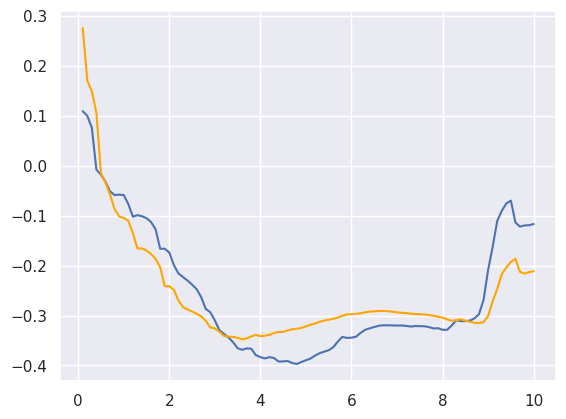

In [444]:
L = 1
steerAngle = lambda x: x

pred_la = vEgo[1:] ** 2 * np.sin(steerAngle(steerCommands))[:-1] / L

a = np.sum((pred_la - pred_la.mean()) * (steer_la[1:] - steer_la[1:].mean())) / np.sum((pred_la - pred_la.mean()) ** 2)
b = steer_la[1:].mean() - a * pred_la.mean()

pred_la = pred_la * a + b

plt.plot(t[1:], steer_la[1:])
plt.plot(t[1:], pred_la, color='orange')
plt.show()

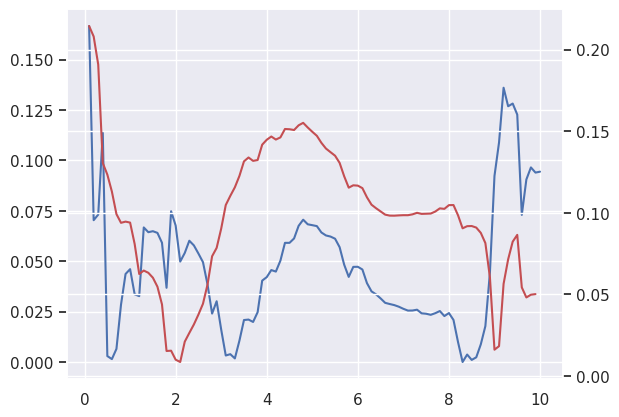

In [445]:
fig, ax1 = plt.subplots()
ax1.plot(t[1:], np.abs(steer_la[1:] - pred_la))
ax2 = ax1.twinx()
ax2.plot(t[1:], np.abs(steerCommands[1:]), color='r')
plt.show()

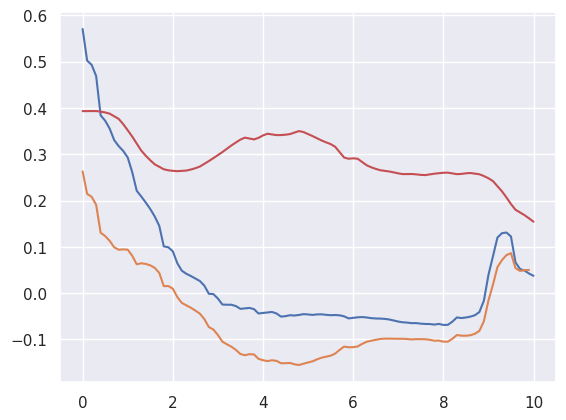

In [446]:
plt.plot(t, target_la)
plt.plot(t, roll_la, color='r')
plt.plot(t, steerCommands)
plt.show()

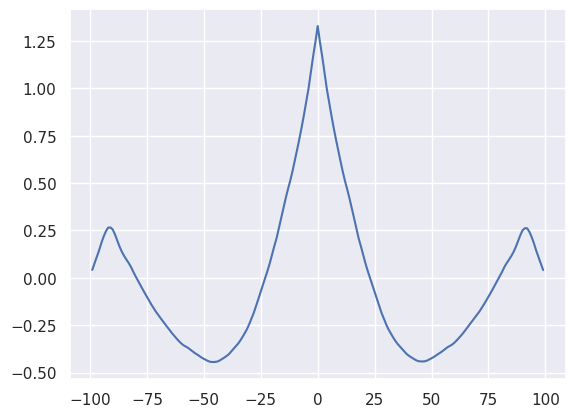

0


In [447]:
corr = signal.correlate(steer_la[:100] - steer_la[:100].mean(), steerCommands[:100] - steerCommands[:100].mean())
lags = signal.correlation_lags(100, 100)
plt.plot(lags, corr)
plt.show()
print(lags[np.argmax(corr)])

In [ ]:
def plot_rollout(sim):
  fig, ax = plt.subplots(figsize=(10, 5))
  ax.plot(sim.target_lataccel_history, label="Target Lateral Acceleration", alpha=0.5)
  ax.plot(sim.current_lataccel_history, label="Actual Lateral Acceleration", alpha=0.5)
  ax.legend()
  ax.set_xlabel("Step")
  ax.set_ylabel("Lateral Acceleration")
  ax.set_title("Rollout")
  plt.show()

In [ ]:
model = TinyPhysicsModel("./models/tinyphysics.onnx", debug=True)
controller = pid.Controller()

In [ ]:
sim = TinyPhysicsSimulator(model, "./data/00000.csv", controller=controller, debug=False)
sim.rollout()

In [ ]:
plot_rollout(sim)